## Analyzing borrowers’ risk of defaulting

Your project is to prepare a report for a bank’s loan division. We'll find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. We'll use the bank's data on customers’ credit worthiness.

Your report will be considered when building a **credit scoring** of a potential customer. A ** credit scoring ** is used to evaluate the ability of a potential borrower to repay their loan.

** debt: whether the customer has ever defaulted on a loan **

### Step 1. Open the data file and have a look at the general information. 

Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.stem import SnowballStemmer 
english_stemmer = SnowballStemmer('english')
import numpy as np
from collections import Counter

In [2]:
try:
    df = pd.read_csv('/datasets/credit_scoring_eng.csv')    
except:
    df = pd.read_csv('C:\VBA\Data Analyst\Data_preprocessing\Final/credit_scoring_eng.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
#UPDATE COLUMNS HEADER NAMES
df.columns =['children_number', 'days_employed', 'birthdate', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose']
df.shape

(21525, 12)

In [4]:
df.head()

,children_number,days_employed,birthdate,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


###### Lets analyse missing values statistics

In [5]:
print(df.isnull().sum())

children_number        0
days_employed       2174
birthdate              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


###### Processing duplicates

In [6]:
dv = df[df.duplicated()]
print(dv.shape)
dv.head()

(54, 12)


,children_number,days_employed,birthdate,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41,secondary education,1,married,0,F,employee,0,NaN,purchase of the house for my family
4182,1,NaN,34,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,NaN,wedding ceremony
4851,0,NaN,60,secondary education,1,civil partnership,1,F,retiree,0,NaN,wedding ceremony
5557,0,NaN,58,secondary education,1,civil partnership,1,F,retiree,0,NaN,to have a wedding
7808,0,NaN,57,secondary education,1,civil partnership,1,F,retiree,0,NaN,having a wedding


###### It seems that all duplicate rows are for Non-employed clients since "Days_employed" and "Total_income" columns are Null. This might derive from a mistake of the clients who submitted this info.

###### For the purpose of our analysis, I will remove duplicate rows

In [7]:
df = df.drop_duplicates()

### Analyze the children_number column.

##### We can notice for "-1" and "20" values in the  children column. I will assume that this is a mistake/typo and therefore will repalce "-1" with "1" and "20" with "2"

In [8]:
num_of_children= df['children_number'].value_counts().reset_index()
num_of_children.columns= ['children','quantity']
num_of_children

,children,quantity
0,0,14107
1,1,4809
2,2,2052
3,3,330
4,20,76
5,-1,47
6,4,41
7,5,9


### Change ages to 1 and 2

In [9]:
df.loc[df['children_number'] == -1,'children_number'] = 1
df.loc[df['children_number'] == 20,'children_number'] = 2
print(df['children_number'].unique())


[1 0 3 2 4 5]


In [10]:
num_of_children= df['children_number'].value_counts().reset_index()
num_of_children.columns= ['children','quantity']
num_of_children['child_perc'] = num_of_children['quantity']/num_of_children['quantity'].sum()*100
num_of_children

,children,quantity,child_perc
0,0,14107,65.702576
1,1,4856,22.616553
2,2,2128,9.911043
3,3,330,1.536957
4,4,41,0.190955
5,5,9,0.041917


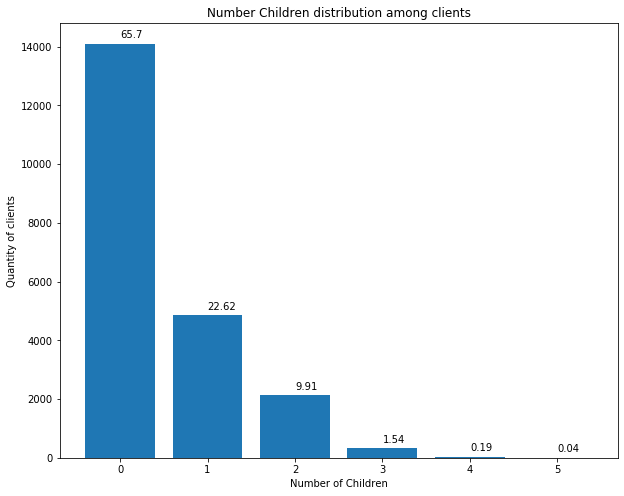

In [11]:
fix, ax = plt.subplots(figsize = (10,8))

plt.bar(num_of_children.children, num_of_children.quantity)
plt.xlabel("Number of Children")
plt.ylabel("Quantity of clients")
plt.title("Number Children distribution among clients")


for row in num_of_children.itertuples():
    ax.text(row.children, row.quantity+200, round(row.child_perc,2) )

#####  Most of clients have None or One child. 

In [12]:
df.debt.unique()

array([0, 1], dtype=int64)

In [13]:
df['defaulted']= df['debt'].apply(lambda x: "no" if x==0 else "yes")

## Kids | Loan Default Analysis
##### Lets create a pivot table to summarize the portions and proportions of clients who defaulted on loan repayment

In [14]:
child_analysis = df.pivot_table(index='children_number',columns = 'defaulted', values ='debt', aggfunc= 'count', fill_value=0)
child_analysis

defaulted,no,yes
children_number,,
0,13044,1063
1,4411,445
2,1926,202
3,303,27
4,37,4
5,9,0


In [15]:
# child_analysis.columns = child_analysis.columns.astype(str)
# child_analysis = child_analysis.reset_index()

In [16]:
# child_analysis['no_perc'] = child_analysis.sum(axis=1)
child_analysis['no_%'] = child_analysis['no']/child_analysis[['no','yes']].sum(axis=1)
child_analysis['yes_%'] = child_analysis['yes']/child_analysis[['no','yes']].sum(axis=1)
child_analysis

defaulted,no,yes,no_%,yes_%
children_number,,,,
0,13044,1063,0.924647,0.075353
1,4411,445,0.908361,0.091639
2,1926,202,0.905075,0.094925
3,303,27,0.918182,0.081818
4,37,4,0.902439,0.097561
5,9,0,1.000000,0.000000


In [17]:
child_analysis.sort_values(by='yes_%', ascending=False)

defaulted,no,yes,no_%,yes_%
children_number,,,,
4,37,4,0.902439,0.097561
2,1926,202,0.905075,0.094925
1,4411,445,0.908361,0.091639
3,303,27,0.918182,0.081818
0,13044,1063,0.924647,0.075353
5,9,0,1.000000,0.000000


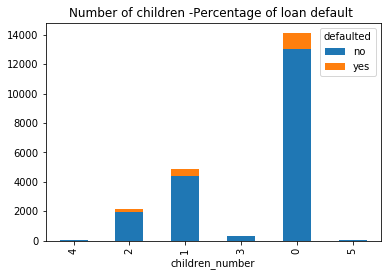

In [18]:
child_analysis.sort_values(by='yes_%', ascending=False)[['no','yes']].plot(kind='bar', stacked=True, title='Number of children -Percentage of loan default ');

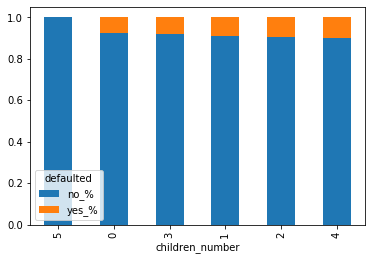

In [19]:
child_analysis.sort_values(by='yes_%')[['no_%','yes_%']].plot(kind='bar', stacked=True);

###### From the above chart we may notice that customers with 4 kids have the highest default rates. However the absolute value of 4 kids clients is immaterial.

## days_employed: 

###### dealing with negative numbers
##### Replace "days_employed" and "total_income" missing values to 0 - I assume that users didn't insert any input because they do not work.

In [20]:
df['days_employed'].fillna(0,inplace=True)
df['total_income'].fillna(0,inplace=True)

###### Change days_employed to INT datatype

In [21]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
# df.isnull().sum()

- Lets review the number of years emplyed amont clients
- We may notice unreasonable years (around 1000) - lets fix this
- We can also notice negative years - lets fix this

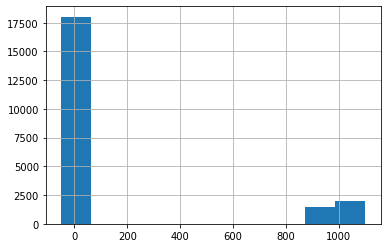

In [22]:
(df['days_employed']/365).hist();

In [23]:
print(df['days_employed'].describe())

count     21471.000000
mean      56821.712496
std      135009.925299
min      -18388.000000
25%       -2522.000000
50%        -989.000000
75%           0.000000
max      401755.000000
Name: days_employed, dtype: float64


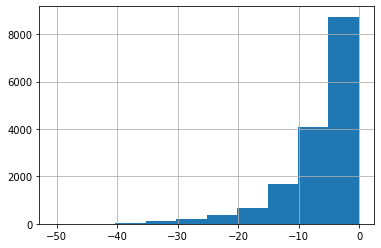

In [24]:
(df[df['days_employed']<0]['days_employed']/365).sort_values(ascending=False).hist();

#### From the above we can see that the negative days (translated to years) seems as reasonable number of working years, therefore I'll assume that the negative days are a human mistake and should have been entered as positive number.

### Lets change the negative numbers to positive ( Days of employment).

In [25]:
df['days_employed'] =df['days_employed'].abs()

In [26]:
df['days_employed'].describe()

count     21471.000000
mean      60307.263611
std      133489.332460
min           0.000000
25%         620.000000
50%        1818.000000
75%        4794.000000
max      401755.000000
Name: days_employed, dtype: float64

- Lets subset the abnormal values for "number of years" - we may see that the average number of years is 1000, therefore it is reasonable that number were multiplied times 100.

- Action: lets divide in 100 abnormal values .


In [27]:
df[df['days_employed']>50000]['days_employed'].mean()

365003.8092888244

In [28]:
print('Abnormal average years of work', df[df['days_employed']>50000]['days_employed'].mean()/365)

Abnormal average years of work 1000.010436407738


- Divide in 100 all abnormal days of emplyment.

In [29]:
df['days_employed']= df['days_employed'].apply(lambda x: x/100 if x > 100000 else x)

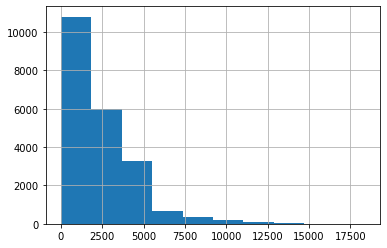

In [30]:
(df['days_employed']).hist();

In [31]:
doe = df[['days_employed','defaulted']].sort_values(by='days_employed')
doe['years'] =(doe['days_employed']/365).astype('int')
doe.head()

,days_employed,defaulted,years
3913,0.0,no,0
7323,0.0,no,0
11218,0.0,no,0
7328,0.0,no,0
19564,0.0,no,0


In [32]:
doe= doe.groupby(['years','defaulted']).agg({'defaulted':'count'}).rename(columns={'defaulted':'qnt'}).reset_index()
doe.head()

,years,defaulted,qnt
0,0,no,3584
1,0,yes,363
2,1,no,1785
3,1,yes,238
4,2,no,1675


In [33]:
doe= doe.pivot(index='years',columns='defaulted',values='qnt').fillna(0)
doe.head()

defaulted,no,yes
years,,
0,3584.0,363.0
1,1785.0,238.0
2,1675.0,203.0
3,1418.0,142.0
4,1246.0,104.0


- The below is to enable the reset_index function.

In [34]:
doe.reset_index(inplace=True)

In [35]:
doe.set_index('years',inplace=True)
doe.head()

defaulted,no,yes
years,,
0,3584.0,363.0
1,1785.0,238.0
2,1675.0,203.0
3,1418.0,142.0
4,1246.0,104.0


In [36]:
doe['total'] = doe[['no','yes']].sum(axis=1)
doe['loan_default_perc'] = (doe['yes'] / doe[['no','yes']].sum(axis=1))*100
doe.head()

defaulted,no,yes,total,loan_default_perc
years,,,,
0,3584.0,363.0,3947.0,9.196858
1,1785.0,238.0,2023.0,11.764706
2,1675.0,203.0,1878.0,10.809372
3,1418.0,142.0,1560.0,9.102564
4,1246.0,104.0,1350.0,7.703704


- Lets consider years with substantial amount of cliens, therefore let's filter years with more than 100 clients

In [37]:
doe= doe[doe['total']>100]

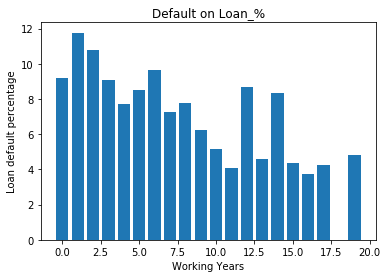

In [38]:
plt.bar(doe.index, doe.loan_default_perc)
plt.xlabel("Working Years")
plt.ylabel("Loan default percentage")
plt.title("Default on Loan_%")
plt.show()

###### From the above chart we may notice that the less years of employment the higher percentage of loan default.

### Income level vs Repaying loan analysis

- Is there a relation between income level and repaying a loan on time?

In [39]:
df.head()

,children_number,days_employed,birthdate,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,defaulted
0,1,8437.00,42,bachelor's degree,0,married,0,F,employee,0,40620,purchase of the house,no
1,1,4024.00,36,secondary education,1,married,0,F,employee,0,17932,car purchase,no
2,0,5623.00,33,Secondary Education,1,married,0,M,employee,0,23341,purchase of the house,no
3,3,4124.00,32,secondary education,1,married,0,M,employee,0,42820,supplementary education,no
4,0,3402.66,53,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding,no


In [40]:
total_income = df[['total_income','debt']]
total_income.describe()

,total_income,debt
count,21471.000000,21471.000000
mean,24142.173909,0.081086
std,17564.008086,0.272974
min,0.000000,0.000000
25%,14231.000000,0.000000
50%,21714.000000,0.000000
75%,31320.000000,0.000000
max,362496.000000,1.000000


In [41]:
def income_level(income_column):
    if income_column <= 14254:
        return'low'
    if income_column <= 21721:
        return 'average'
    else:
        return 'high'

In [42]:
df['income_cat'] = df['total_income'].apply(income_level)

In [43]:
df['income_cat'].unique()

array(['high', 'average', 'low'], dtype=object)

In [44]:
df.education_id.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [45]:
income_analysis= df.groupby('income_cat').agg({'debt':{'sum','count'}}).reset_index()
income_analysis.columns = ['income_cat','default','total']
income_analysis['default_perc'] = income_analysis['default'] /income_analysis['total']*100
income_analysis

,income_cat,default,total,default_perc
0,average,457,5361,8.524529
1,high,865,10728,8.063013
2,low,419,5382,7.785210


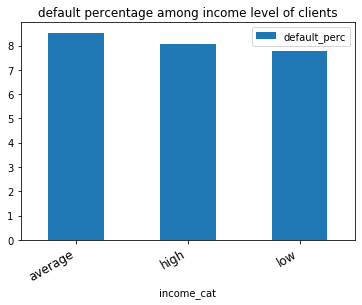

In [46]:
ax = income_analysis.plot(x='income_cat', y='default_perc', kind='bar',title='default percentage among income level of clients')

ax.set_xticklabels(income_analysis['income_cat'],rotation=30,fontdict={'horizontalalignment':'right','size':12});

###### From the above chart we may notice that clients with average income have the highest rates of default while clients with lowest income category have the lowest rate of loan default

### MARITAL STATUS vs REPAYING LOAN ANALYSIS

In [47]:
df[['family_status','family_status_id','debt']].head()

,family_status,family_status_id,debt
0,married,0,0
1,married,0,0
2,married,0,0
3,married,0,0
4,civil partnership,1,0


In [48]:
for i in df['family_status'].unique():
    print(i)

married
civil partnership
widow / widower
divorced
unmarried


In [49]:
general = df['family_status'].value_counts()
general

married              12344
civil partnership     4163
unmarried             2810
divorced              1195
widow / widower        959
Name: family_status, dtype: int64

In [50]:
marital_s = df.groupby('family_status').agg({'debt':'sum'})
marital_s

,debt
family_status,
civil partnership,388
divorced,85
married,931
unmarried,274
widow / widower,63


- Lets group by famility status and combine with the number of "debt" cases for each status.
- Lets calculate the debt ratio per each status group to analyse absolute & proportional amounts.

In [51]:
marital_s= marital_s.merge(general,left_index=True,right_index=True)
marital_s['no_debt'] = marital_s['family_status']-marital_s['debt']
marital_s['debt_perc'] = marital_s['debt']/marital_s['family_status']
marital_s['no_debt_perc']= marital_s['no_debt']/marital_s['family_status']
marital_s

,debt,family_status,no_debt,debt_perc,no_debt_perc
civil partnership,388,4163,3775,0.093202,0.906798
divorced,85,1195,1110,0.071130,0.928870
married,931,12344,11413,0.075421,0.924579
unmarried,274,2810,2536,0.097509,0.902491
widow / widower,63,959,896,0.065693,0.934307


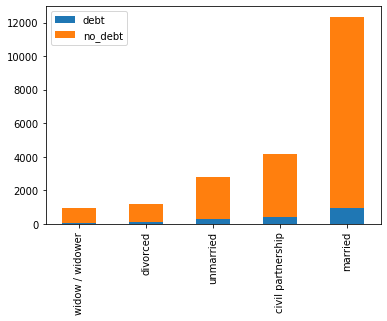

In [52]:
marital_s.sort_values(by='debt')[['debt','no_debt']].plot(kind='bar', stacked=True);

### Per the above bar chart my see that married status clients have the largest number of loan default.

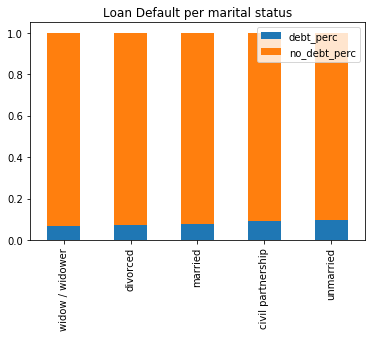

In [53]:
marital_s.sort_values(by='debt_perc')[['debt_perc','no_debt_perc']].plot(kind='bar', stacked=True, title = 'Loan Default per marital status');

###### Per the above bar-chart my see that unmarried-status clients have the largest percent of loan default.

### How do different loan purposes affect on-time repayment of the loan?
Steps:
1. Clean the "purpose" column by stemming and lemmatication.
2. Find the most common categoreis
3. Categorize the "purpose" column based on the most common results.
4. Set a pivot table with the category column as Index and calculate the sum, count and rations of each category.
5. Calculations based on PT.

In [54]:
def lemma_stem_purchase_column(column_name):
    
    words = word_tokenize(column_name)
    lemmas = [lemmatizer.lemmatize(w) for w in words]
    stem_words = [english_stemmer.stem(i) for i in lemmas]
    
    join_lemmas =  " ".join(stem_words)
    return join_lemmas
    

In [55]:
df['purpose_clear'] = df['purpose'].apply(lemma_stem_purchase_column)
df.head()

,children_number,days_employed,birthdate,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,defaulted,income_cat,purpose_clear
0,1,8437.00,42,bachelor's degree,0,married,0,F,employee,0,40620,purchase of the house,no,high,purchas of the hous
1,1,4024.00,36,secondary education,1,married,0,F,employee,0,17932,car purchase,no,average,car purchas
2,0,5623.00,33,Secondary Education,1,married,0,M,employee,0,23341,purchase of the house,no,high,purchas of the hous
3,3,4124.00,32,secondary education,1,married,0,M,employee,0,42820,supplementary education,no,high,supplementari educ
4,0,3402.66,53,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding,no,high,to have a wed


**Lets Check the most frequesnt reasonts for loan:**

In [56]:
Counter(df['purpose_clear'].values.tolist()).most_common()

[('car', 972),
 ('wed ceremoni', 793),
 ('have a wed', 773),
 ('to have a wed', 769),
 ('real estat transact', 675),
 ('buy commerci real estat', 662),
 ('hous transact', 652),
 ('buy properti for rent out', 652),
 ('transact with commerci real estat', 650),
 ('purchas of the hous', 646),
 ('hous', 646),
 ('purchas of the hous for my famili', 638),
 ('construct of own properti', 635),
 ('properti', 633),
 ('transact with my real estat', 627),
 ('build a real estat', 625),
 ('buy real estat', 621),
 ('purchas of my own hous', 620),
 ('build a properti', 619),
 ('hous renov', 607),
 ('buy residenti real estat', 606),
 ('buy my own car', 505),
 ('go to univers', 496),
 ('second-hand car purchas', 486),
 ('to own a car', 479),
 ('buy a second-hand car', 478),
 ('to buy a car', 472),
 ('car purchas', 461),
 ('supplementari educ', 460),
 ('purchas of a car', 455),
 ('univers educ', 452),
 ('educ', 447),
 ('to get a supplementari educ', 447),
 ('get an educ', 442),
 ('profil educ', 436),
 ('g

- a function to generate a category column for loan purposes

In [57]:
def cat_purpose(data):
    
    if ("hous" in data):
        return 'home purchase'
    if ('real estat' in data) or ('properti' in data):
        return 'real estate'
    if 'wed' in data:
        return 'wedding'
    if 'car' in data:
        return 'car'
    if 'educ' in data:
        return 'education'
    return 'other'

In [58]:
df['purpose_cat'] = df['purpose_clear'].apply(cat_purpose)
df.head()

,children_number,days_employed,birthdate,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,defaulted,income_cat,purpose_clear,purpose_cat
0,1,8437.00,42,bachelor's degree,0,married,0,F,employee,0,40620,purchase of the house,no,high,purchas of the hous,home purchase
1,1,4024.00,36,secondary education,1,married,0,F,employee,0,17932,car purchase,no,average,car purchas,car
2,0,5623.00,33,Secondary Education,1,married,0,M,employee,0,23341,purchase of the house,no,high,purchas of the hous,home purchase
3,3,4124.00,32,secondary education,1,married,0,M,employee,0,42820,supplementary education,no,high,supplementari educ,education
4,0,3402.66,53,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding,no,high,to have a wed,wedding


In [59]:
loan_cat = df['purpose_cat'].value_counts().reset_index()
loan_cat

,index,purpose_cat
0,real estate,7005
1,car,4308
2,home purchase,3809
3,education,3518
4,wedding,2335
5,other,496


In [60]:
cat_loan= df.groupby('purpose_cat').agg({'debt':{'count','sum'}}).reset_index()
cat_loan.columns = ['category','default_number','total_clients']
cat_loan


,category,default_number,total_clients
0,car,403,4308
1,education,327,3518
2,home purchase,256,3809
3,other,43,496
4,real estate,526,7005
5,wedding,186,2335


In [61]:
cat_loan['default_percent'] =cat_loan['default_number'] / cat_loan['total_clients'] 
cat_loan['no_default_percent'] = 1- (cat_loan['default_number'] / cat_loan['total_clients'])

cat_loan

,category,default_number,total_clients,default_percent,no_default_percent
0,car,403,4308,0.093547,0.906453
1,education,327,3518,0.092951,0.907049
2,home purchase,256,3809,0.067209,0.932791
3,other,43,496,0.086694,0.913306
4,real estate,526,7005,0.075089,0.924911
5,wedding,186,2335,0.079657,0.920343


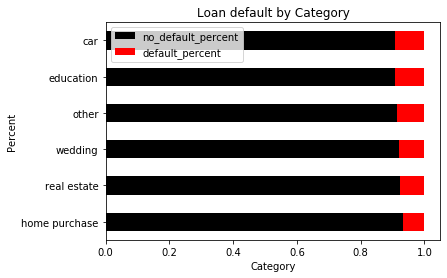

In [62]:
cat_loan.set_index('category')[['no_default_percent','default_percent']].sort_values(
    by='default_percent').plot(kind='barh', stacked=True, title ='Loan default by Category', color=['black','red']);


# plt.xticks(rotation=30, horizontalalignment="center");
plt.xlabel("Category");
plt.ylabel("Percent");

### Per above chart we may notice that clients who loaned money for the purpose of buying car or education had the largerst default rate.

### Conclusions:

- 66% of the clients have no kids, 23% have one kid and 10% have 2 kids.
- We can notice that clients with 4 kids had higher loan default percentage compared to clients with less kids although their portion is smaller compared to clients with no kids..
- Working days - based on the chart we note that loan default percentage reduces to clients with longer working years.

- Income level: per analysis we note that clients with average income have higher loan default rates compared to clients with lower income

- Marital status - Married clients are the majority of clients however “unmarried” clients have the highest rate of loan default
